In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig, TrainingArguments, Trainer
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
from datasets import load_dataset,load_metric
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

from captum.attr import IntegratedGradients
import sys

accelerator = Accelerator()
device = accelerator.device

/opt/crc/c/conda/23.5.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


# Load Model

In [2]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)
# set to eval mode
pred_model.eval()

inputs = processor(images=image, return_tensors="pt")
inputs.to(device)
outputs = pred_model(**inputs, output_hidden_states=True)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

Predicted class: golden retriever


In [3]:
ig = IntegratedGradients(lambda x: torch.softmax(pred_model(pixel_values=x).logits, dim=-1))

input_img = inputs['pixel_values']
attribution_ig = ig.attribute(input_img, target=predicted_class_idx, n_steps=200)

## Show Example

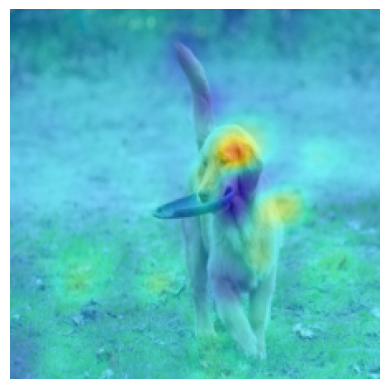

In [4]:
from utils.img_utils import unnormalize, unnormalize_and_255_scale, show_superimposed, get_overlap, plot_overlap, plot_overlap_np

def get_heatmap(attribution_ig):
    # heatmap = torch.relu(attribution_ig.sum(dim=1))
    heatmap = attribution_ig.sum(dim=1)
    # Average pooling to convert to 14*14 heatmap
    heatmap = F.avg_pool2d(heatmap, kernel_size=16, stride=16)
    heatmap = heatmap.squeeze(0).detach().cpu().numpy()
    return heatmap

img = inputs['pixel_values'].squeeze(0).detach().cpu().numpy().transpose(1,2,0)
# img = unnormalize_and_255_scale(img, mean, std)
heatmap = get_heatmap(attribution_ig)

img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

# Batch Evaluation

In [29]:
from torch.utils.data import DataLoader
def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

_, _, test_ds = load_data()

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

test_ds.set_transform(preprocess)

# batch size is limited to 2, because n_steps could could huge memory consumption
test_dataloader = DataLoader(test_ds, batch_size=2, collate_fn=collate_fn)

Repo card metadata block was not found. Setting CardData to empty.


In [30]:
from evaluation import EvalGame

model = lambda x: pred_model(pixel_values=x).logits

ig = IntegratedGradients(lambda x: torch.softmax(model(x), dim=-1))

eval_game = EvalGame(model=lambda x : pred_model(pixel_values=x).logits, output_dim=1000)

ins_score_list = []
del_score_list = []

for idx, data in enumerate(test_dataloader):
    pixel_values = data['pixel_values'].to(device)
    with torch.no_grad():
        pseudo_label = model(pixel_values).argmax(-1).view(-1)

    # sum up all 3 RGB channels for heatmap
    attribution_ig = ig.attribute(pixel_values, target=pseudo_label, n_steps=100)
    heatmap = attribution_ig.sum(dim=1)

    save_heatmap(heatmap, root_path)

    with torch.no_grad():
        # Average pooling to convert to 14*14 heatmap
        heatmap = F.avg_pool2d(heatmap, kernel_size=16, stride=16)
        ins_score = eval_game.get_insertion_at_topk(input_img, heatmap, topk=20).detach()
        del_score = eval_game.get_deletion_at_topk(input_img, heatmap, topk=20).detach()

        # append to list
        ins_score_list.append(ins_score)
        del_score_list.append(del_score)
    
    if idx == 5:
        break

ins_score = torch.cat(ins_score_list, dim=0)
del_score = torch.cat(del_score_list, dim=0)
        
        

        

In [33]:

ins_score

tensor([1.4679e-03, 1.7338e-02, 6.5515e-03, 4.6700e-02, 1.2395e-01, 8.4748e-04,
        3.3239e-01, 1.9283e-04, 1.5053e-03, 1.7068e-03, 3.0213e-02, 1.7916e-03],
       device='cuda:0')

In [34]:
del_score

tensor([0.9004, 0.9322, 0.7714, 0.8217, 0.6872, 0.8312, 0.7121, 0.9390, 0.9138,
        0.9200, 0.8467, 0.9431], device='cuda:0')

tensor([0.8875, 0.9157, 0.8900], device='cuda:0', grad_fn=<SumBackward1>)

In [10]:
os.getcwd()

'/afs/crc.nd.edu/user/d/dpan/wd/llama_exp'